# Generating LPM trajectories showing creation and annihilation
Tim Tyree <br>
3.29.2025

In [1]:
from lib import *
from lib.my_initialization import *
plt.plot([1]*4)
plt.close()
#reset matplotlib
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
mpl.rcParams.update(matplotlib.rcParamsDefault) #reset matplotlib

# define module

In [2]:
# @njit
def sqdiff(x1, x2):
    return pow((x1-x2),2)

# @njit
def min3(num1, num2, num3):
    if (num1 > num2 ):
        mn=num2
    else:
        mn=num1
    if (mn>num3):
        mn=num3
    return mn

# @njit
def dist_pbc(x1, y1, x2, y2, L):
    # returns the smallest dist of each possible pbc combination
    xsq1 = sqdiff(x1,x2)
    xsq2 = sqdiff(x1,x2+L)
    xsq3 = sqdiff(x1,x2-L)
    ysq1 = sqdiff(y1,y2)
    ysq2 = sqdiff(y1,y2+L)
    ysq3 = sqdiff(y1,y2-L)
    xsq  = min3(xsq1,xsq2,xsq3)
    ysq  = min3(ysq1,ysq2,ysq3)
    return np.sqrt(xsq+ysq)

# @njit
def subtract_pbc_1d(x1, x2, L):
    # returns the smallest dist of each possible pbc combination
    dx = x1-x2
    dx1 = x1-x2+L
    dx2 = x1-x2-L
    if (abs(dx1)<abs(dx)):
        dx=dx1;
    else:
        if (abs(dx2)<abs(dx)):
            dx=dx2
    return dx

# @njit
def reflection(X, L):
    return L-abs(L-abs(X % 2.*L))
# @njit
def periodic(X, L):
    x=X % L
    if (x<0.):
        return x+L
    return x
# def seed_new_particle(x_new,y_new,still_running,L,R_c_bar,max_num_retries=100):
#     """
#     Example Usage:
# xg,yg=seed_new_particle(x_new,y_new,still_running,L,R_c_bar,max_num_retries=100)
#     """
#     xg=np.random.uniform(0,1)*L
#     yg=np.random.uniform(0,1)*L
#     mindist=2.*L
#     for j in np.argwhere(still_running).flatten():
#         dist=dist_pbc(xg,yg,x_new[j],y_new[j],L);
#         if dist<mindist:
#             mindist=dist
#     #while new particle is within distance R_c_bar from any other particle
#     num=0
#     while (mindist<R_c_bar) and (num<max_num_retries):
#         num+=1
#         xg=np.random.uniform(0,1)*L
#         yg=np.random.uniform(0,1)*L
#         mindist=2.*L
#         for j in np.argwhere(still_running).flatten():
#             dist=dist_pbc(xg,yg,x_new[j],y_new[j],L);
#             if dist<mindist:
#                 mindist=dist
#     return xg,yg

# dev visualization of LPM motion with creation

            FK LR
    D (cm2/s) 0.115 ± 0.008 0.42 ± 0.14
    a (cm2/s) 1.552 ± 0.017 9.3 ±0.3
    r (cm) 0.457±0.009 0.314±0.003
    κ (Hz) 15 75

          FK LR
    δ (s) 0.1 0.1
    r0 (cm) 0.131 ± 0.001 0.202 ± 0.003
    b (cm2/s) 3.01±0.05 10.0 ± 0.5
    Rc (cm) 0.85 1.25

In [3]:
#recall LPM movement parameters for the FK model
D = 0.115 #cm^2/s FK
# D = 0.42 #cm^2/s LR
a = 1.552 #cm^2/s FK
# a = 9.3 #cm^2/s LR
r = 0.457 #cm FK
# r = 0.314 #cm LR
kappa = 15 #Hz FK
# kappa = 75 #Hz LR

#recall LPM creation parameters for the FK model
Rc = 0.85 # cm FK
# Rc = 1.25 # cm LR
creation_duration = 0.1 #s #both FK and LR
b = 3.01 #±0.05 cm^2/s FK
# b = 10.0 #±0.5 cm^2/s LR
r0 = 1.31 #±0.001 cm FK
# r0 = 0.202 #±0.003 cm LR

In [4]:
#place 2 particles at a given initial angle (theta0=-pi/4) centered about the origin
theta0=-np.pi/4
rc = Rc/2.
xy0_self = rc*np.array([np.cos(theta0),np.sin(theta0)])
xy0_other = rc*np.array([np.cos(theta0+np.pi),np.sin(theta0+np.pi)])

In [5]:
dt = 1e-5
# seed = 42
# seed = 5 #beautiful++
# # seed = 8 #beautiful+
# # seed = 12 #gorgeous
seed=13 #beautiful++
#heretim
# tmax = 30. #seconds
tmax = 3. #seconds
# tmax = .3 #seconds
printing=True
np.random.seed(seed)
rsq = r**2
t = 0
xy_lst_self = [xy0_self]
xy_lst_other = [xy0_other]
#time evolve their trajectories with no other creations/particles
nsteps = int(tmax/dt)
step = 0
while t<tmax:
    step +=1
    t+=dt
    #recall positions
    xy_self = xy_lst_self[-1]
    xy_other = xy_lst_other[-1]
    Rsq = np.sum((xy_self - xy_other) ** 2)
    x_self_next = xy_self[0]
    x_other_next = xy_other[0]
    y_self_next = xy_self[1]
    y_other_next = xy_other[1]
    dx = (x_other_next - x_self_next).copy()
    dy = (y_other_next - y_self_next).copy()
#     #apply repulsive force
#     if t<creation_duration:
#         x_self_next+=dt*b*dx/Rsq
#         x_other_next-=dt*b*dx/Rsq
#         y_self_next+=dt*b*dy/Rsq
#         y_other_next-=dt*b*dy/Rsq
    #apply repulsive force
    if t<creation_duration:
        x_self_next-=dt*b*dx/Rsq
        x_other_next+=dt*b*dx/Rsq
        y_self_next-=dt*b*dy/Rsq
        y_other_next+=dt*b*dy/Rsq
#     #apply attractive force
#     x_self_next-=dt*a*dx/Rsq
#     x_other_next+=dt*a*dx/Rsq
#     y_self_next-=dt*a*dy/Rsq
#     y_other_next+=dt*a*dy/Rsq
    #apply attractive force
    x_self_next+=dt*a*dx/Rsq
    x_other_next-=dt*a*dx/Rsq
    y_self_next+=dt*a*dy/Rsq
    y_other_next-=dt*a*dy/Rsq
    #apply noise
    Dcoeff = np.sqrt(2.*D*dt)
    x_self_next += Dcoeff*np.random.normal()
    x_other_next+= Dcoeff*np.random.normal()
    y_self_next+=  Dcoeff*np.random.normal()
    y_other_next+= Dcoeff*np.random.normal()
    #record
    xy_self = np.array([x_self_next,y_self_next])
    xy_other = np.array([x_other_next,y_other_next])
    xy_lst_self.append(xy_self)
    xy_lst_other.append(xy_other)
    if printing and (step % 1000 == 0):
        printProgressBar(step,nsteps)    
    #implement capture stop condition
    if Rsq<rsq:
        p = np.random.rand()
        if p<kappa*dt:
            tmax = t
print(f"\n{tmax=}")

 |██████----------------------------------------------------------------------------------------------| 6.0% 
tmax=0.18222000000004146


In [6]:
xy_values_self = np.stack(xy_lst_self)
xy_values_other = np.stack(xy_lst_other)

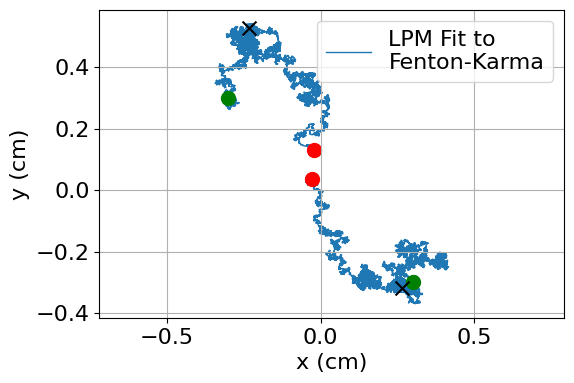

In [7]:
#TODO: visualize like in Fig. 1B in the annihilation dynamics paper
color = 'C0'
fontsize=16
lw=1
fig,ax=plt.subplots(figsize=(6,4))
#plot birth
plt.scatter([xy_values_self[0,0]],[xy_values_self[0,1]],color='green',s=100)
plt.scatter([xy_values_other[0,0]],[xy_values_other[0,1]],color='green',s=100)
try:
    #plot repulsion turning off
    ioff = int(creation_duration/dt)
    plt.scatter([xy_values_self[ioff,0]],[xy_values_self[ioff,1]],color='k',s=100,marker='x')
    plt.scatter([xy_values_other[ioff,0]],[xy_values_other[ioff,1]],color='k',s=100,marker='x')
except IndexError as e:
    pass
#plot death
plt.scatter([xy_values_self[-1,0]],[xy_values_self[-1,1]],color='red',s=100)
plt.scatter([xy_values_other[-1,0]],[xy_values_other[-1,1]],color='red',s=100)


plt.plot(xy_values_self[:,0],xy_values_self[:,1],color=color,lw=lw,zorder=-1)
plt.plot(xy_values_other[:,0],xy_values_other[:,1],color=color,lw=lw,zorder=-1,label='LPM Fit to\nFenton-Karma')
# plt.plot(xy_values_other[:,0],xy_values_other[:,1],color='gray',lw=2)

format_plot(fontsize=fontsize,xlabel='x (cm)',ylabel='y (cm)')
ax = plt.gca()
ax.grid('on')
ax.axis('equal')
ax.legend(fontsize=fontsize)
plt.show()

# TODO: repeat for LR model in a separate panel

In [8]:
#recall LPM movement parameters for the FK model
# D = 0.115 #cm^2/s FK
D = 0.42 #cm^2/s LR
# a = 1.552 #cm^2/s FK
a = 9.3 #cm^2/s LR
# r = 0.457 #cm FK
r = 0.314 #cm LR
# kappa = 15 #Hz FK
kappa = 75 #Hz LR

#recall LPM creation parameters for the FK model
# Rc = 0.85 # cm FK
Rc = 1.25 # cm LR
creation_duration = 0.1 #s #both FK and LR
# b = 3.01 #±0.05 cm^2/s FK
b = 10.0 #±0.5 cm^2/s LR
# r0 = 1.31 #±0.001 cm FK
r0 = 0.202 #±0.003 cm LR

In [9]:
#place 2 particles at a given initial angle (theta0=-pi/4) centered about the origin
# theta0=-np.pi/4
theta0=+np.pi/4
rc = Rc/2.
xy0_self = rc*np.array([np.cos(theta0),np.sin(theta0)])
xy0_other = rc*np.array([np.cos(theta0+np.pi),np.sin(theta0+np.pi)])

In [10]:
dt = 1e-5
# seed = 42
seed = 5 #beautiful++
# # seed = 8 #beautiful+
# # seed = 12 #gorgeous
# # seed=13 #beautiful++
#heretim
# tmax = 30. #seconds
# tmax = 3. #seconds
tmax = .3 #seconds
printing=True
np.random.seed(seed)
rsq = r**2
t = 0
xy_lst_self = [xy0_self]
xy_lst_other = [xy0_other]
#time evolve their trajectories with no other creations/particles
nsteps = int(tmax/dt)
step = 0
while t<tmax:
    step +=1
    t+=dt
    #recall positions
    xy_self = xy_lst_self[-1]
    xy_other = xy_lst_other[-1]
    Rsq = np.sum((xy_self - xy_other) ** 2)
    x_self_next = xy_self[0]
    x_other_next = xy_other[0]
    y_self_next = xy_self[1]
    y_other_next = xy_other[1]
    dx = x_other_next - x_self_next
    dy = y_other_next - y_self_next
#     #apply repulsive force
#     if t<creation_duration:
#         x_self_next+=dt*b*dx/Rsq
#         x_other_next-=dt*b*dx/Rsq
#         y_self_next+=dt*b*dy/Rsq
#         y_other_next-=dt*b*dy/Rsq
    #apply repulsive force
    if t<creation_duration:
        x_self_next-=dt*b*dx/Rsq
        x_other_next+=dt*b*dx/Rsq
        y_self_next-=dt*b*dy/Rsq
        y_other_next+=dt*b*dy/Rsq
#     #apply attractive force
#     x_self_next-=dt*a*dx/Rsq
#     x_other_next+=dt*a*dx/Rsq
#     y_self_next-=dt*a*dy/Rsq
#     y_other_next+=dt*a*dy/Rsq
    #apply attractive force
    x_self_next+=dt*a*dx/Rsq
    x_other_next-=dt*a*dx/Rsq
    y_self_next+=dt*a*dy/Rsq
    y_other_next-=dt*a*dy/Rsq
    #apply noise
    Dcoeff = np.sqrt(2.*D*dt)
    x_self_next += Dcoeff*np.random.normal()
    x_other_next+= Dcoeff*np.random.normal()
    y_self_next+=  Dcoeff*np.random.normal()
    y_other_next+= Dcoeff*np.random.normal()
    #record
    xy_self = np.array([x_self_next,y_self_next])
    xy_other = np.array([x_other_next,y_other_next])
    xy_lst_self.append(xy_self)
    xy_lst_other.append(xy_other)
    if printing and (step % 1000 == 0):
        printProgressBar(step,nsteps)    
    #implement capture stop condition
    if Rsq<rsq:
        p = np.random.rand()
        if p<kappa*dt:
            tmax = t
print(f"\n{tmax=}")

 |████████████████████████████████████████████████████████████████████████████------------------------| 76.7% 
tmax=0.23944000000009869


In [11]:
xy_values_self = np.stack(xy_lst_self)
xy_values_other = np.stack(xy_lst_other)

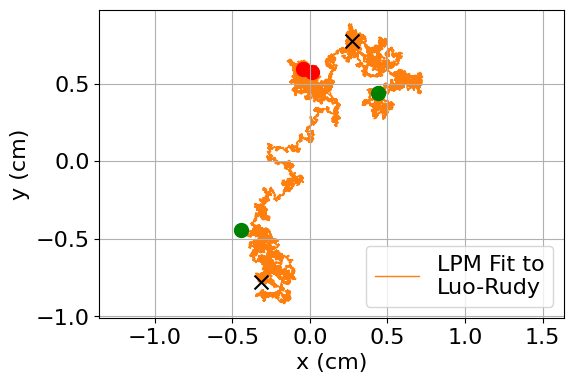

In [12]:
#TODO: visualize like in Fig. 1B in the annihilation dynamics paper
color = 'C1'
fontsize=16
lw=1
fig,ax=plt.subplots(figsize=(6,4))
#plot birth
plt.scatter([xy_values_self[0,0]],[xy_values_self[0,1]],color='green',s=100)
plt.scatter([xy_values_other[0,0]],[xy_values_other[0,1]],color='green',s=100)
try:
    #plot repulsion turning off
    ioff = int(creation_duration/dt)
    plt.scatter([xy_values_self[ioff,0]],[xy_values_self[ioff,1]],color='k',s=100,marker='x')
    plt.scatter([xy_values_other[ioff,0]],[xy_values_other[ioff,1]],color='k',s=100,marker='x')
except IndexError as e:
    pass
#plot death
plt.scatter([xy_values_self[-1,0]],[xy_values_self[-1,1]],color='red',s=100)
plt.scatter([xy_values_other[-1,0]],[xy_values_other[-1,1]],color='red',s=100)


plt.plot(xy_values_self[:,0],xy_values_self[:,1],color=color,lw=lw,zorder=-1)
plt.plot(xy_values_other[:,0],xy_values_other[:,1],color=color,lw=lw,zorder=-1,label='LPM Fit to\nLuo-Rudy')
# plt.plot(xy_values_other[:,0],xy_values_other[:,1],color='gray',lw=2)

format_plot(fontsize=fontsize,xlabel='x (cm)',ylabel='y (cm)')
ax = plt.gca()
ax.grid('on')
ax.axis('equal')
ax.legend(fontsize=fontsize)
plt.show()